In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from tqdm import tqdm
from PIL import Image
from argparse import ArgumentParser


In [95]:
track = 3
data_dir = f'/workspace/Mapillary/MKU/kitti360/labels/{track}/'#label images directory
support_dir = f'/workspace/KITTI-360/data_2d_semantics/train/2013_05_28_drive_000{track}_sync/semantic/'#label images directory
new_dir = f'/workspace/Mapillary/MKU/kitti360/corrected_labels/{track}/'#Where to save new dataset
config = 'config.csv'#CSV file consisting data for conversion

In [113]:
#getting all filenames in a given folder to process them
original = [os.path.join(dp, f) for dp, dn, fn in os.walk(os.path.expanduser(data_dir)) for f in fn]
original.sort()

support = [os.path.join(dp, f) for dp, dn, fn in os.walk(os.path.expanduser(support_dir)) for f in fn]
support.sort()

if not os.path.exists(new_dir):
    os.makedirs(new_dir)
    
#loading config in pandas dataframe
instruction = pd.read_csv(config)


#palette to paint new images
palette = instruction['Palette'].dropna().tolist()
palette = [list(map(int, i.split(':')[1].split('-'))) for i in palette]
palette = [item for sublist in palette for item in sublist]

In [114]:
#getting necessary data from config:
#supporting information
order = instruction['Mapillary-Kitti-Priority'].dropna().tolist()
order = [int(i) if ';' not in i else i for i in order]
print(order)

[13, 4, 2, '7k;4', '8k;2', 0, 1, 3, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17, 18, 19, '23k;0', 20]


100%|██████████| 1/1 [00:00<00:00,  1.87it/s]


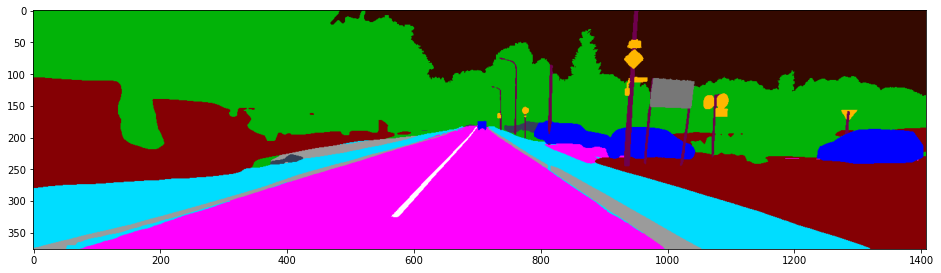

In [116]:
#going through images
for image_path in tqdm(original):
    image_name = new_dir + image_path.split('/')[-1].replace('_prediction', '') #If you have changed your image names
    corr = support_dir + image_path.split('/')[-1].replace('_prediction', '')   #you would need to correct this 
    if os.path.exists(corr):
        image = np.array(Image.open(image_path))
        sup = np.array(Image.open(corr))
        new_image = np.zeros(image.shape)
        #transfering labels class by class
        for i, cls in enumerate(order):
            if type(cls) != str:
                new_image[image==cls] = cls
            else:
                new, old = cls.split(';')
                new = new[:-1]
                new_image[sup==int(new)] = old

        #saving colored images
        new_image = Image.fromarray(new_image.astype(np.uint8))
        new_image.putpalette(palette)
        new_image.save(image_name, "PNG")

        #adjusting permissions
        os.chmod(image_name, 775)
    else:
        image = np.array(Image.open(image_path))
        new_image = Image.fromarray(image.astype(np.uint8))
        new_image.putpalette(palette)
        new_image.save(image_name, "PNG")
        
plt.figure(figsize=(16,8))
plt.imshow(new_image)